In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from random import seed
%matplotlib inline

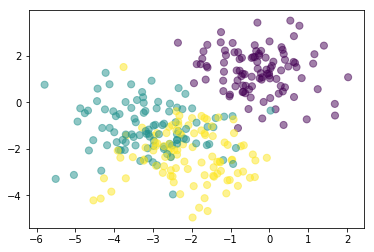

In [2]:
X,y = make_blobs(center_box = (-3,3),n_samples = 300,random_state = 1)
plt.scatter(X[:,0],X[:,1], c = y, s = 50, alpha = 0.5)

In [3]:
class KMeans:
    
    def __init__(self, k):
        self.k = k
    
    def get_clusters(self,X):
        
        distances = np.zeros((len(X), self.k))
        for center in range(len(self.centers)):
            distances[:,center] = ((X-self.centers[center,:])**2).sum(axis = 1)
            
        return np.argmin(distances,axis = 1)
    
    
    def compute_new_centers(self,X,labels):
        
        for center in range(len(self.centers)):
            tmp = X[labels == center,:]
            if len(tmp) == 0:
                continue
            self.centers[center,:] = tmp.mean(axis = 0)
    
    def fit(self,X):
        
        self.centers = np.random.randn(self.k, X.shape[1])
        labels = self.get_clusters(X)
        previous_clusters = np.zeros_like(labels)
        #print(self.centers)
        
        while not np.array_equal(previous_clusters,labels):
            
            previous_clusters = labels.copy()
            self.compute_new_centers(X, labels)
            labels = self.get_clusters(X)
            #print(self.centers)
            
    def predict(self,X):
        return self.get_clusters(X)
                  

In [4]:
testkmeans = KMeans(3)

In [5]:
testkmeans.fit(X)

In [6]:
preds = testkmeans.predict(X)

In [7]:
testkmeans.centers

array([[-1.92335225, -2.7133335 ],
       [-3.1007804 , -1.00532027],
       [-0.29585022,  1.29129834]])

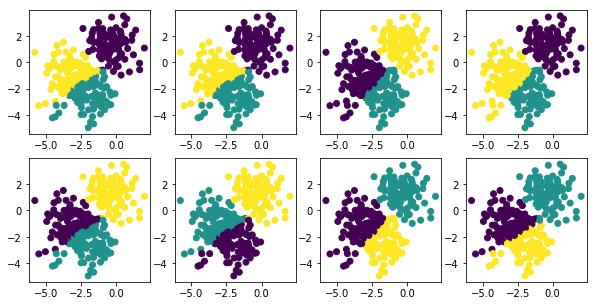

In [8]:
fig, ax = plt.subplots(2,4, figsize=(10,5))
ax = ax.flatten()

for a in ax:
    testkmeans = KMeans(3)
    testkmeans.fit(X)
    preds = testkmeans.predict(X)
    a.scatter(X[:,0],X[:,1], c = preds)

As can be seen above kmeans doesn't always converge to the same clusters. It depends on the random initialization of the centers. As a solution, we could repeat this process several times and accept the answer with the lowest sum of distances to the nearest center.

An interesting idea is that like most supervised machine learning models, sometimes we want to know the probability of being in a class as opposed to just the prediction. Kmeans can be adapted in a similar fashion by considering the distances of a point to each cluster center to assign this probability. 

In [9]:
class SoftKMeans:
    
    def __init__(self, k, beta = 1):
        self.k = k
        self.beta = beta
        self.costs = []
        
    def get_responsibilities(self,X):
        
        distances = np.zeros((len(X), self.k))
        for center in range(len(self.centers)):
            distances[:,center] = ((X-self.centers[center,:])**2).sum(axis = 1)
        
        exp_distances = np.exp(-self.beta*distances)
        responsibilities = exp_distances/exp_distances.sum(axis = 1).reshape(-1,1)
        
        return responsibilities
    
    
    def compute_new_centers(self,X,responsibilities):
        
        for center in range(self.k):
            self.centers[center,:] = (responsibilities[:,center].reshape(-1,1)/responsibilities[:,center].sum()).T.dot(X)
    
    def get_cost(self,X,responsibilities):
        distances = np.zeros((len(X), self.k))
        for center in range(self.k):
            distances[:,center] = ((X-self.centers[center,:])**2).sum(axis = 1)
            
        costs = distances*responsibilities
        self.costs.append(costs.sum())
        return(costs.sum())
        
    
    def fit(self,X):
        
        self.centers = np.random.randn(self.k, X.shape[1])
        responsibilities = self.get_responsibilities(X)
        previous_cost = np.Inf
        cost = self.get_cost(X,responsibilities)
        while (previous_cost - cost) > .001 :
            previous_cost = cost
            self.compute_new_centers(X, responsibilities)
            responsibilities = self.get_responsibilities(X)
            cost = self.get_cost(X,responsibilities)
            
            
    def predict(self,X):
        responsibilities = self.get_responsibilities(X)
        return np.argmax(responsibilities,axis = 1), responsibilities
                  

In [10]:
softkmeans = SoftKMeans(3)
softkmeans.fit(X)

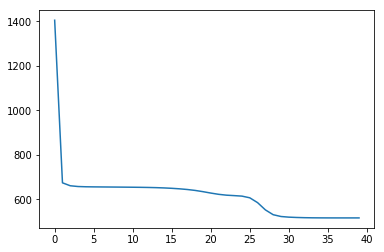

In [11]:
plt.plot(softkmeans.costs)

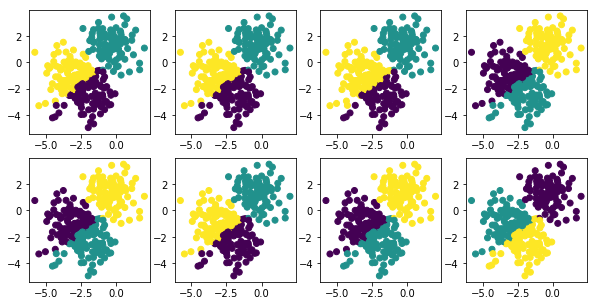

In [12]:
fig, ax = plt.subplots(2,4, figsize=(10,5))
ax = ax.flatten()

for a in ax:
    softkmeans = SoftKMeans(3)
    softkmeans.fit(X)
    preds, reponsibilities = softkmeans.predict(X)
    a.scatter(X[:,0],X[:,1], c = preds)

In this case we know the correct K. What if we didn't?

Text(0.5,1,'K vs Costs')

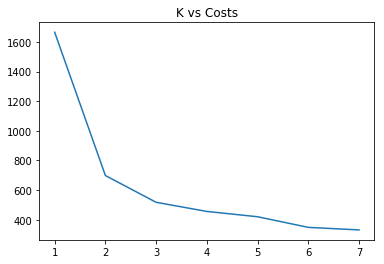

In [13]:
klist = list(range(1,8))
costs = []

for k in klist:
    softkmeans = SoftKMeans(k)
    softkmeans.fit(X)
    costs.append(softkmeans.costs[-1])
    
plt.plot(klist, costs)
plt.title('K vs Costs')

We see a fast decrease in costs from k = 1 to 2, followed by a steady decline to k=4, followed by a leveling out of the costs. In this case we may choose k = 2 or 4. Although the data was generated with k=3, there is obvious overlapping of the data, making it look like it could have been generated from a different k != 3.

A weaklness of kmeans is that all of the clusters are spherical by design. What if the clusters are ellptical in nature? Gaussian mixture models can help with that by modeling clusters as multivariate normal clouds. By tuning the covariance matrix the clusters can take on elliptical shapes instead of just spheres.

In [14]:
from scipy.stats import multivariate_normal
class GaussianMixtureModels:
    
    def __init__(self, k):
        self.k = k
        self.costs = []
        
    def get_responsibilities(self,X):
        
        
        probs = np.zeros((len(X), self.k))
        for center in range(len(self.centers)):
            probs[:,center] = multivariate_normal.pdf(X, mean = self.centers[center,:],
                                                     cov = self.cov[center,:,:]) * self.pi[center]
        
        responsibilities = probs/probs.sum(axis = 1, keepdims=True)
        return responsibilities, probs
    
    
    def compute_new_parameters(self,X,responsibilities):
        
        for center in range(self.k):
            N_k = responsibilities[:,center].sum()
            self.pi[center] = N_k/len(X)
            self.centers[center,:] = (1/N_k)*(responsibilities[:,center].dot(X))

            diff = X-self.centers[center,:]
            rcov = responsibilities[:,center].reshape(-1,1)*diff
            self.cov[center,:,:] = (1/N_k)*(rcov.T.dot(diff)) + np.eye(X.shape[1])*.001
            # adding np.eye *.001 to prevent singular covariance matrix.
    def get_cost(self,probs):

        return(-np.log(probs.sum(axis=1)).sum())
        
    
    def fit(self,X):
        self.centers =  X[np.random.choice(len(X),self.k),:]
        self.cov = np.repeat(np.eye(X.shape[1]).reshape(1,X.shape[1],X.shape[1]),
                             self.k, axis=0)
        self.pi = np.ones(self.k)/self.k
        

        responsibilities, probs = self.get_responsibilities(X)
        previous_cost = np.Inf
        cost = self.get_cost(probs)
        self.costs.append(cost)
        while np.abs(previous_cost - cost) > .1 :
            previous_cost = cost
            self.compute_new_parameters(X, responsibilities)
            responsibilities, probs = self.get_responsibilities(X)
            cost = self.get_cost(probs)
            self.costs.append(cost)

            
    def predict(self,X):
        responsibilities,_ = self.get_responsibilities(X)
        return np.argmax(responsibilities,axis = 1), responsibilities
                  

In [15]:
testGMM = GaussianMixtureModels(3)

In [16]:
testGMM.fit(X)

In [17]:
preds, _ = testGMM.predict(X)

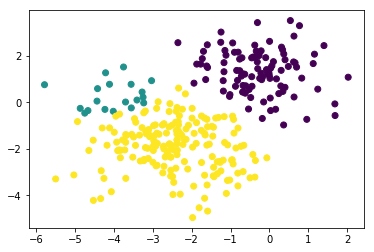

In [18]:
plt.scatter(X[:,0],X[:,1], c = preds)

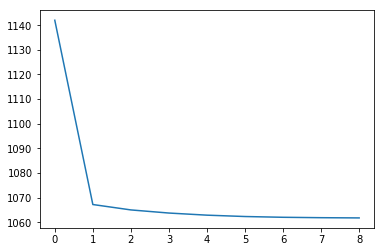

In [19]:
plt.plot(testGMM.costs)

In [20]:
X1 = np.random.multivariate_normal(size= 100,mean = [2,2],cov = np.array([[1,.75],[.75,1]]))
X2 = np.random.multivariate_normal(size= 100,mean = [1,-1],cov = np.array([[2,1.5],[1.5,2]]))
X3 = np.random.multivariate_normal(size= 100,mean = [5,5],cov = np.array([[1,0],[0,1]]))

X = np.vstack([X1,X2,X3])
y = np.hstack([np.repeat(0,len(X1)), np.repeat(1, len(X2)), np.repeat(2, len(X3))])

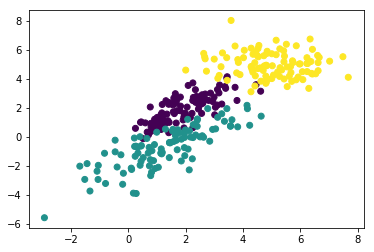

In [21]:
plt.scatter(X[:,0],X[:,1], c = y)

In [22]:
kmeans = KMeans(3)
gmm = GaussianMixtureModels(3)

In [23]:
kmeans.fit(X)
gmm.fit(X)

In [24]:
kmeans_preds = kmeans.predict(X)
gmm_preds,_ = gmm.predict(X)

Text(0.5,1,'GMM')

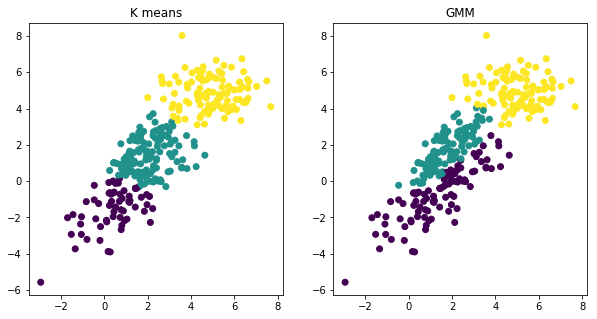

In [25]:
fig, axes = plt.subplots(ncols = 2, figsize = (10,5))
axes[0].scatter(X[:,0],X[:,1], c = kmeans_preds)
axes[0].set_title('K means')
axes[1].scatter(X[:,0],X[:,1], c = gmm_preds)
axes[1].set_title('GMM')

As shown above, in contrast to kmeans methods, Gaussian mixture models can accomodate elliptical shapes because it uses a covariance matrix.

In [26]:
gmm.cov

array([[[ 2.39513647,  2.15061275],
        [ 2.15061275,  2.84456209]],

       [[ 0.84950465,  0.85829137],
        [ 0.85829137,  1.39277272]],

       [[ 1.28442389, -0.05369508],
        [-0.05369508,  0.7624677 ]]])